In [87]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import utils
plt.style.use('ggplot')
pd.set_option('display.max_columns', 200)
pd.set_option('display.float_format', lambda x: '%.10f' % x)


In [88]:
# load data
df = utils.load_suicide_healthcare_gini_df()
test_df = df[df.year == 2015]
train_df = df[df.year < 2015]

In [89]:
print(f"{train_df.shape=} | {test_df.shape=}")

train_df.shape=(1788, 14) | test_df.shape=(276, 14)


## split dataset
use year 2015 as test, 2010 - 2014 as train
=> split of 86 / 14


/var/folders/v4/5kdk6t_57x3gwhsz8x8jl_900000gn/T/ipykernel_49161/2568060914.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train_df.corr(),annot=True)


<AxesSubplot: >

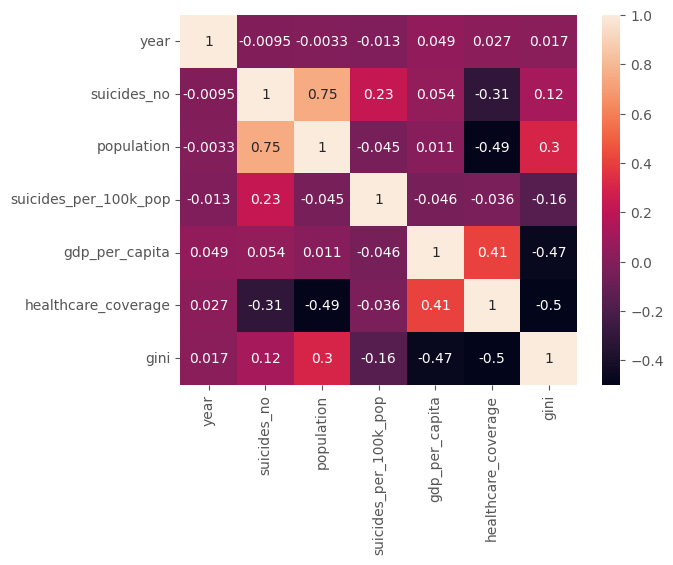

In [90]:
sns.heatmap(train_df.corr(),annot=True)

In [91]:
df.head()


,country,year,sex,age,suicides_no,population,suicides_per_100k_pop,gdp_for_year,gdp_per_capita,generation,country_code,continent,healthcare_coverage,gini
0,Australia,2010,male,35-54 years,816,3076853,26.5200000000,"1,144,260,547,873",54887,Generation X,AUS,Oceania,100.0000000000,34.7000000000
1,Australia,2010,male,75+ years,151,582009,25.9400000000,"1,144,260,547,873",54887,Silent,AUS,Oceania,100.0000000000,34.7000000000
2,Australia,2010,male,25-34 years,311,1606526,19.3600000000,"1,144,260,547,873",54887,Generation X,AUS,Oceania,100.0000000000,34.7000000000
3,Australia,2010,male,55-74 years,360,2051197,17.5500000000,"1,144,260,547,873",54887,Silent,AUS,Oceania,100.0000000000,34.7000000000
4,Australia,2010,male,15-24 years,222,1618860,13.7100000000,"1,144,260,547,873",54887,Millenials,AUS,Oceania,100.0000000000,34.7000000000


In [92]:
X_cols = ['year','gdp_per_capita','healthcare_coverage','gini','population']
X_train = train_df[X_cols].values
Y_train = train_df['suicides_no'].values

X_test = test_df[X_cols].values
Y_test = test_df['suicides_no'].values

In [93]:
# take a look
# X_train.plot.scatter(x='year',)

In [94]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# create a standard scaler object and fit it to the training data
scaler = MinMaxScaler()#StandardScaler()
scaler.fit(X_train)

# transform the training and test data using the scaler
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

## Linear regression model

In [95]:
#Import linear regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

linear_model = LinearRegression()
linear_model.fit(X_train_std, Y_train)

LinearRegression()

In [96]:
# prediction
y_pred = linear_model.predict(X_test_std)
mean_squared_error(y_true=Y_test, y_pred=y_pred)

414725.10760211566

(276,) (276,)


array([ 1.65639918e+01,  1.12670127e+02,  1.68770265e+02,  4.29210133e+01,
        6.28090301e+01,  5.18381027e+01,  1.25551068e+02,  1.67726117e+02,
        4.73920176e+01,  6.06082918e+01,  3.35616841e+01,  3.67730362e+01,
        7.59214014e+01,  2.56655746e+02,  2.00116907e+02,  1.27620831e+02,
        2.51579296e+02,  1.10289344e+02,  2.09678051e+02,  1.18868024e+02,
        1.27233814e+02,  1.15424862e+02,  1.11210433e+02,  1.15711433e+02,
       -2.55654056e+02, -8.46089902e+01,  7.42045736e+01, -8.26632895e+01,
       -8.36014529e+01,  7.49392298e+01, -6.14928547e+01, -8.99426310e+01,
       -9.23510297e+01, -2.26687744e+02, -1.10051691e+02, -1.02861566e+02,
       -2.80771168e+02,  2.87659984e+02,  9.21603731e+01,  2.56452171e+02,
        5.86979929e+02,  2.68092380e+02,  2.62186365e+02,  6.52022998e+02,
       -2.48035282e+02,  1.59907180e+02,  2.42635681e+02,  2.68035927e+02,
        1.21449065e+02,  2.65757938e+02,  3.27282010e+02,  1.94179413e+02,
        1.64857155e+02,  

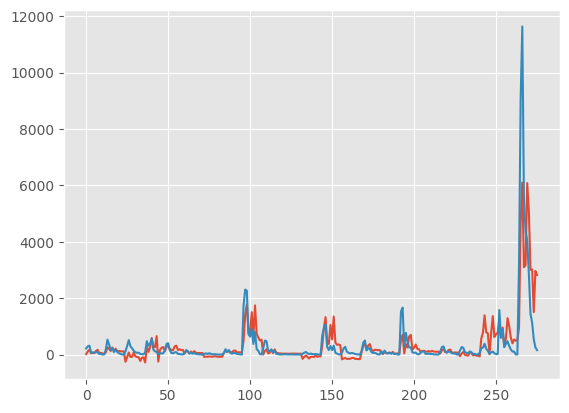

In [100]:
sns.lineplot(y_pred)
sns.lineplot(Y_test)
print(y_pred.shape,Y_test.shape)

<AxesSubplot: >

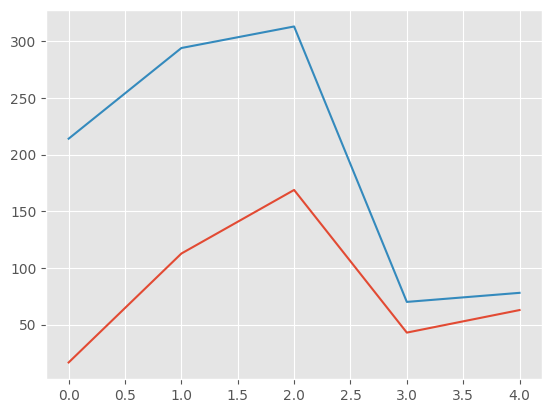

In [102]:
# look at an example
# X_test_std[:2,:]
pred = linear_model.predict(X_test_std[:5,:])
pred_df = pd.DataFrame({
    'pred' : pred,
    'gt': Y_test[:5]
})
sns.lineplot(pred)
sns.lineplot(Y_test[:5])
# X_test.shape